✓ Imagem carregada com sucesso: ../ex1/img/segmentada.png
  Dimensões: 229x295 pixels


### 1. Fecho Convexo (Convex Hull)

**Explicação Teórica:** O Fecho Convexo (ou 'Casco Convexo') é o menor polígono *convexo* que contém todos os pontos da forma. Imagine esticar um elástico ao redor de todos os pontos da borda; a forma desse elástico é o fecho convexo.

### 2. Aproximação Poligonal

**Explicação Teórica:** Utiliza o algoritmo Ramer-Douglas-Peucker (RDP) para simplificar um contorno complexo (com muitos pontos) em um polígono com menos vértices. Ele faz isso definindo uma 'tolerância' (epsilon) de distância máxima que a nova linha pode ter do contorno original.

### 3. Esqueleto do Objeto (Skeleton)

**Explicação Teórica:** Reduz a forma 2D a uma representação 1D (uma 'linha de palito') que é equidistante das bordas. O esqueleto preserva a topologia da forma (quantos 'ramos' ela tem, onde eles se conectam). É calculado por um processo iterativo de 'afinamento' (thinning).

### 4. Assinatura de Forma

**Explicação Teórica:** É uma forma de 'desdobrar' uma forma 2D em um gráfico 1D. Um método comum é plotar a distância do centroide (centro de massa) até cada ponto da borda, em função do ângulo (0-360°). Formas diferentes produzem gráficos 1D únicos.

### 5. Código da Cadeia (Chain Code)

**Explicação Teórica:** Representa o contorno de um objeto armazenando apenas um ponto inicial e uma sequência de 'direções' (códigos de 0 a 7) para o próximo pixel da borda. É uma representação muito compacta. Abaixo, visualizamos o contorno de alta resolução (sem aproximação) que seria usado para gerar esse código.

---

# 📊 Resultados Visuais Comparativos

✓ Imagem salva com sucesso: q2_resultados.png


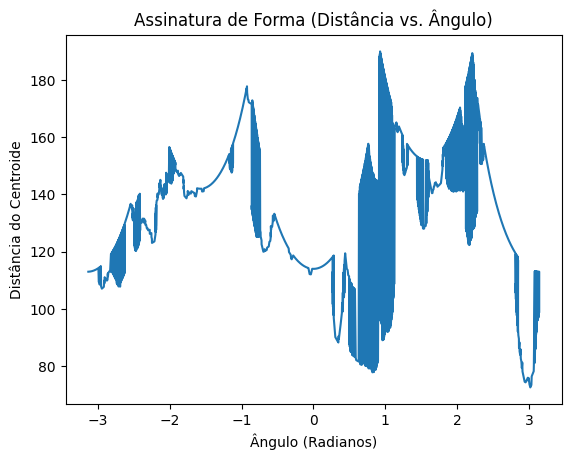

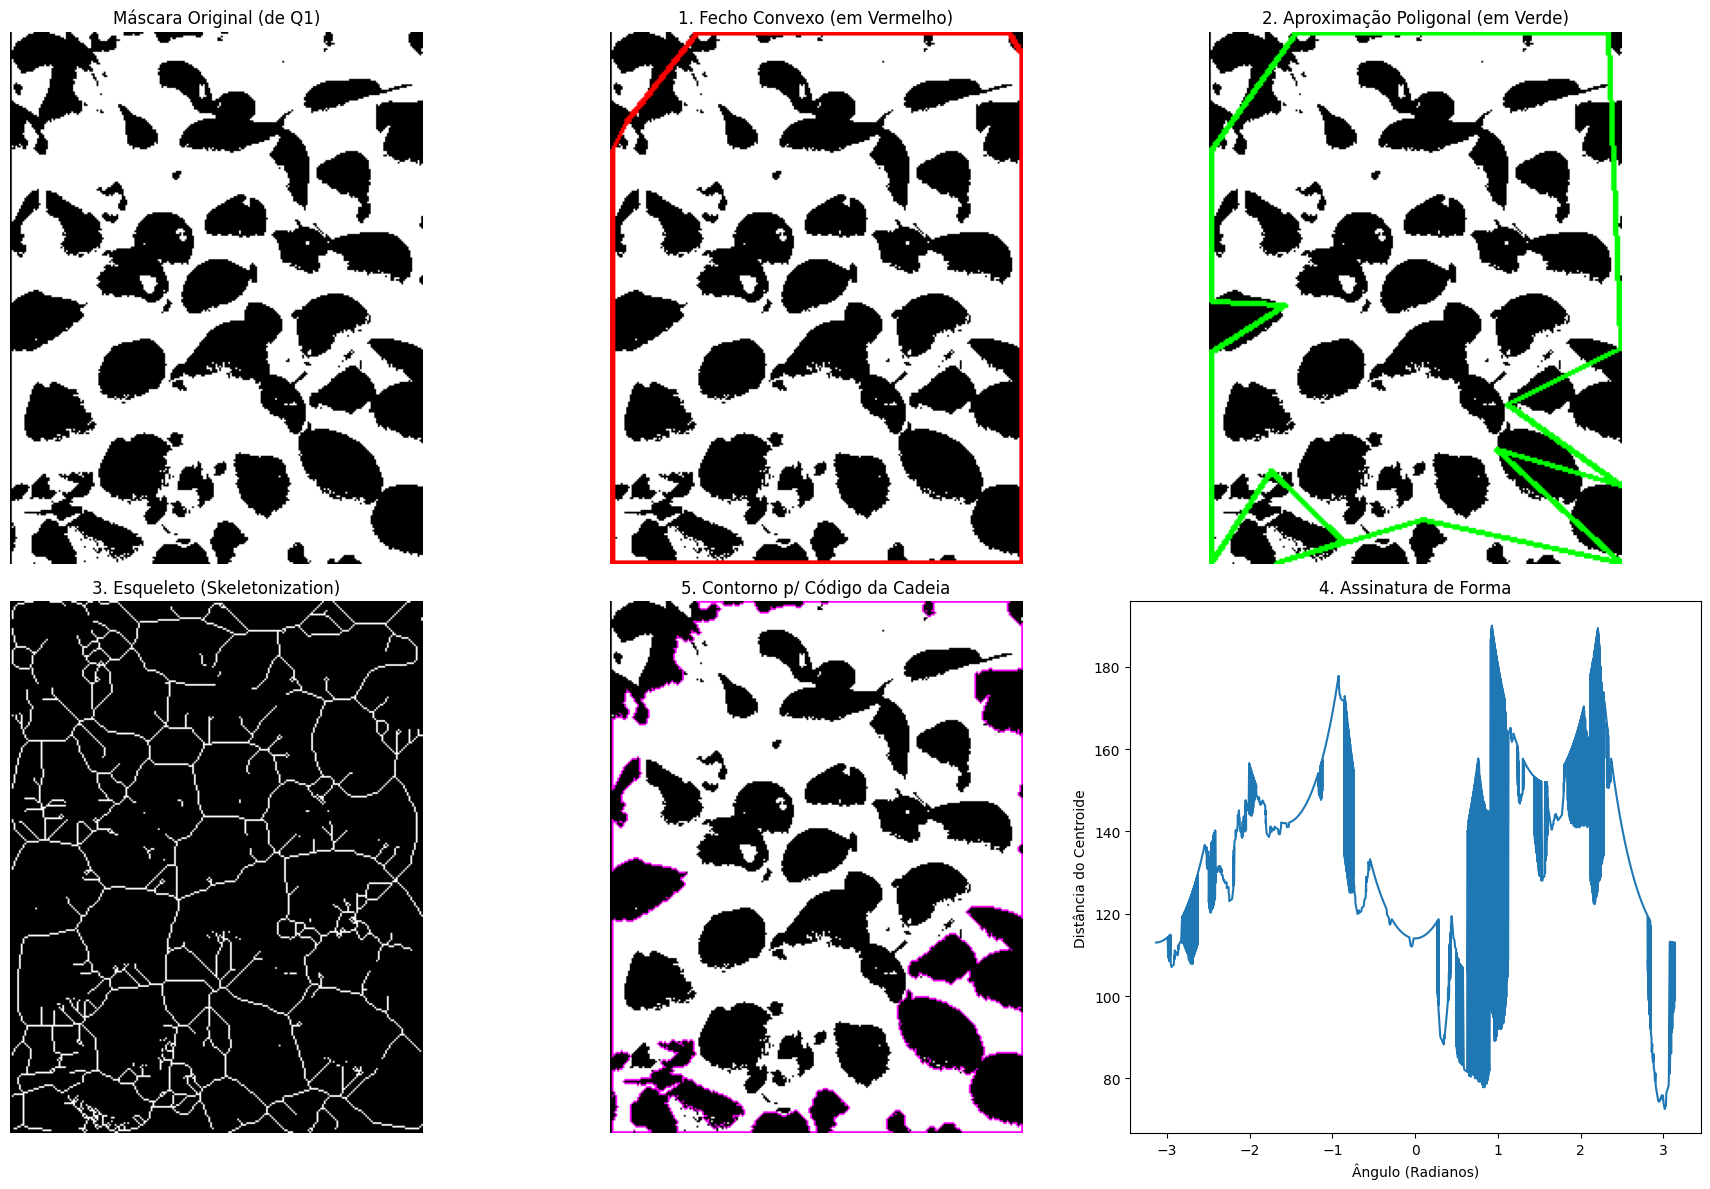

In [7]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from IPython.display import display, Markdown


CAMINHO_IMAGEM = '../ex1/img/segmentada.png'

# =============================================================================

# Carregar a imagem e criar a máscara binária
try:
    img_original = cv2.imread(CAMINHO_IMAGEM, cv2.IMREAD_GRAYSCALE)
    
    if img_original is None:
        raise FileNotFoundError(f"Não foi possível carregar a imagem: {CAMINHO_IMAGEM}")
    
    print(f"✓ Imagem carregada com sucesso: {CAMINHO_IMAGEM}")
    print(f"  Dimensões: {img_original.shape[1]}x{img_original.shape[0]} pixels")
    
    # Nossa imagem de exemplo tem um objeto preto em fundo branco.
    # Para processamento, queremos um objeto branco (255) em fundo preto (0).
    # Usamos THRESH_BINARY_INV (inverso)
    _, mask = cv2.threshold(img_original, 127, 255, cv2.THRESH_BINARY_INV)

    # -----------------------------------------------------------------------------
    # 2. PRÉ-PROCESSAMENTO COMUM: Encontrar Contornos
    # -----------------------------------------------------------------------------
    # A maioria das técnicas usa os contornos do objeto.
    
    # Encontra contornos com aproximação simples (para Hull e Approx)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Encontra contornos com todos os pontos (para Chain Code e Assinatura)
    contours_full, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Selecionamos o maior contorno (assumindo que é o nosso objeto de interesse)
    cnt = max(contours, key=cv2.contourArea)
    cnt_full = max(contours_full, key=cv2.contourArea)

    # Criar uma imagem de base para desenhar (3 canais, colorida)
    h, w = mask.shape
    img_base_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Lista para armazenar os resultados
    resultados = {}

    # -----------------------------------------------------------------------------
    # 3. APLICAÇÃO DAS TÉCNICAS
    # -----------------------------------------------------------------------------

    # --- TÉCNICA 1: Fecho Convexo (Convex Hull) ---
    display(Markdown("### 1. Fecho Convexo (Convex Hull)"))
    display(Markdown("**Explicação Teórica:** O Fecho Convexo (ou 'Casco Convexo') é o menor polígono *convexo* que contém todos os pontos da forma. Imagine esticar um elástico ao redor de todos os pontos da borda; a forma desse elástico é o fecho convexo."))
    
    hull = cv2.convexHull(cnt)
    img_hull = img_base_color.copy()
    cv2.drawContours(img_hull, [hull], 0, (0, 0, 255), 2) # Desenha em Vermelho
    resultados['Fecho Convexo'] = img_hull

    # --- TÉCNICA 2: Aproximação Poligonal ---
    display(Markdown("### 2. Aproximação Poligonal"))
    display(Markdown("**Explicação Teórica:** Utiliza o algoritmo Ramer-Douglas-Peucker (RDP) para simplificar um contorno complexo (com muitos pontos) em um polígono com menos vértices. Ele faz isso definindo uma 'tolerância' (epsilon) de distância máxima que a nova linha pode ter do contorno original."))
    
    # Epsilon = 1% do perímetro do contorno
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    img_approx = img_base_color.copy()
    cv2.drawContours(img_approx, [approx], 0, (0, 255, 0), 2) # Desenha em Verde
    resultados['Aprox. Poligonal'] = img_approx

    # --- TÉCNICA 3: Esqueleto do Objeto (Skeleton) ---
    display(Markdown("### 3. Esqueleto do Objeto (Skeleton)"))
    display(Markdown("**Explicação Teórica:** Reduz a forma 2D a uma representação 1D (uma 'linha de palito') que é equidistante das bordas. O esqueleto preserva a topologia da forma (quantos 'ramos' ela tem, onde eles se conectam). É calculado por um processo iterativo de 'afinamento' (thinning)."))
    
    # skimage.skeletonize espera uma imagem com valores 0 ou 1
    mask_normalized = mask / 255.0
    skeleton = skeletonize(mask_normalized)
    # Converte de volta para 0-255 para visualização
    img_skeleton = (skeleton * 255).astype(np.uint8)
    resultados['Esqueleto'] = img_skeleton

    # --- TÉCNICA 4: Assinatura de Forma ---
    display(Markdown("### 4. Assinatura de Forma"))
    display(Markdown("**Explicação Teórica:** É uma forma de 'desdobrar' uma forma 2D em um gráfico 1D. Um método comum é plotar a distância do centroide (centro de massa) até cada ponto da borda, em função do ângulo (0-360°). Formas diferentes produzem gráficos 1D únicos."))
    
    # Calcular o centroide
    M = cv2.moments(cnt_full)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    distances = []
    angles = []
    
    # Usamos cnt_full para ter uma assinatura mais detalhada
    for point in cnt_full.reshape(-1, 2): # Remodela o contorno
        x, y = point
        # Calcular distância
        d = np.sqrt((x - cx)**2 + (y - cy)**2)
        # Calcular ângulo (atan2 lida com todos os quadrantes)
        a = np.arctan2(y - cy, x - cx)
        
        distances.append(d)
        angles.append(a)

    # Ordenar pelo ângulo para que o gráfico faça sentido
    sorted_indices = np.argsort(angles)
    sorted_angles = np.array(angles)[sorted_indices]
    sorted_distances = np.array(distances)[sorted_indices]
    
    # Salvar o gráfico em um figure do matplotlib
    fig_sig = plt.figure()
    ax_sig = fig_sig.add_subplot(111)
    ax_sig.plot(sorted_angles, sorted_distances)
    ax_sig.set_title("Assinatura de Forma (Distância vs. Ângulo)")
    ax_sig.set_xlabel("Ângulo (Radianos)")
    ax_sig.set_ylabel("Distância do Centroide")
    resultados['Assinatura'] = fig_sig # Salvamos a figura para plotar depois

    # --- TÉCNICA 5: Código da Cadeia (Chain Code) ---
    display(Markdown("### 5. Código da Cadeia (Chain Code)"))
    display(Markdown("**Explicação Teórica:** Representa o contorno de um objeto armazenando apenas um ponto inicial e uma sequência de 'direções' (códigos de 0 a 7) para o próximo pixel da borda. É uma representação muito compacta. Abaixo, visualizamos o contorno de alta resolução (sem aproximação) que seria usado para gerar esse código."))
    
    img_chain_contour = img_base_color.copy()
    # Desenhamos o contorno 'cnt_full' (CHAIN_APPROX_NONE)
    # Isso mostra todos os pixels que seriam convertidos em códigos
    cv2.drawContours(img_chain_contour, [cnt_full], 0, (255, 0, 255), 1) # Magenta, 1px
    
    # A implementação real do código (ex: [0, 7, 7, 6, 5...]) não é trivial
    # A visualização do contorno de origem é suficiente para o relatório
    resultados['Contorno (Chain Code)'] = img_chain_contour

    # -----------------------------------------------------------------------------
    # 4. APRESENTAÇÃO VISUAL DOS RESULTADOS
    # -----------------------------------------------------------------------------
    display(Markdown("---"))
    display(Markdown("# 📊 Resultados Visuais Comparativos"))

    plt.figure(figsize=(18, 12))

    # Plot 1: Máscara Original
    plt.subplot(2, 3, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara Original (de Q1)')
    plt.axis('off')

    # Plot 2: Fecho Convexo
    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(resultados['Fecho Convexo'], cv2.COLOR_BGR2RGB))
    plt.title('1. Fecho Convexo (em Vermelho)')
    plt.axis('off')

    # Plot 3: Aproximação Poligonal
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(resultados['Aprox. Poligonal'], cv2.COLOR_BGR2RGB))
    plt.title('2. Aproximação Poligonal (em Verde)')
    plt.axis('off')

    # Plot 4: Esqueleto
    plt.subplot(2, 3, 4)
    plt.imshow(resultados['Esqueleto'], cmap='gray')
    plt.title('3. Esqueleto (Skeletonization)')
    plt.axis('off')
    
    # Plot 5: Contorno para Chain Code
    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(resultados['Contorno (Chain Code)'], cv2.COLOR_BGR2RGB))
    plt.title('5. Contorno p/ Código da Cadeia')
    plt.axis('off')

    # Plot 6: Assinatura de Forma (Gráfico)
    # Como este é um gráfico, nós o plotamos diretamente no subplot
    ax_plot = plt.subplot(2, 3, 6)
    ax_plot.plot(sorted_angles, sorted_distances)
    ax_plot.set_title("4. Assinatura de Forma")
    ax_plot.set_xlabel("Ângulo (Radianos)")
    ax_plot.set_ylabel("Distância do Centroide")

    plt.tight_layout()
    
    # Salvar a figura como arquivo PNG
    plt.savefig('q2_resultados.png', dpi=300, bbox_inches='tight')
    print(f"✓ Imagem salva com sucesso: q2_resultados.png")
    
    plt.show()

    # Limpar a figura da assinatura que criamos
    plt.close(fig_sig)

except Exception as e:
    print(f"Ocorreu um erro: {e}")
    print("Certifique-se de que o ambiente Colab tem permissão para baixar arquivos (wget) e instalar pacotes (pip).")